In [1]:
#LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV

In [2]:
#DATASETS
early_train = pd.read_csv("../data/Datasets/early_dataset_train.csv")
early_test = pd.read_csv("../data/Datasets/early_dataset_test.csv")
clean_train =pd.read_csv("../data/Datasets/clean_dataset_train.csv")
clean_test =pd.read_csv("../data/Datasets/clean_dataset_test.csv")
sel_train = pd.read_csv("../data/Datasets/sel_dataset_train.csv")
sel_test  = pd.read_csv("../data/Datasets/sel_dataset_test.csv")
#EARLY DATASETS
target = "Outcome"
X_early_train = early_train.drop([target], axis=1)
y_early_train = early_train[target]
X_early_test = early_test.drop([target], axis=1)
y_early_test = early_test[target]
#CLEAN DATASETS
X_clean_train = clean_train.drop([target], axis=1)
y_clean_train = clean_train[target]
X_clean_test = clean_test.drop([target], axis=1)
y_clean_test = clean_test[target]
#SEL DATASETS
X_sel_train = sel_train.drop([target], axis=1)
y_sel_train = sel_train[target]
X_sel_test = sel_test.drop([target], axis=1)
y_sel_test = sel_test[target]

In [3]:
# Hago un diccionario con los datasets
datasets = {
    'early': {'X_train': X_early_train, 'y_train': y_early_train, 'X_test': X_early_test, 'y_test': y_early_test},
    'clean': {'X_train': X_clean_train, 'y_train': y_clean_train, 'X_test': X_clean_test, 'y_test': y_clean_test},
    'sel': {'X_train': X_sel_train, 'y_train': y_sel_train, 'X_test': X_sel_test, 'y_test': y_sel_test}
}
results = {}

for name, data in datasets.items():
    X_train = data['X_train']
    y_train = data['y_train']
    X_test  = data['X_test']
    y_test  = data['y_test']
    
    # Modelo de árbol de decisión
    tree = DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced',   # por el desbalance de Outcome
        # puedes dejar max_depth=None para ver el árbol "libre"
        # o poner un valor (p.ej. 4, 5, 6) para evitar sobreajuste
    )
    
    # Entrenamiento
    tree.fit(X_train, y_train)
    
    # Predicciones
    y_pred = tree.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    
    print("\n================================")
    print(f"   ÁRBOL DE DECISIÓN - {name.upper()}")
    print("================================")
    print("Accuracy:", acc)
    print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
    
    # Guardo el modelo y la accuracy para comparar luego
    results[name] = {
        "model": tree,
        "accuracy": acc
    }


   ÁRBOL DE DECISIÓN - EARLY
Accuracy: 0.7337662337662337

Matriz de confusión:
 [[82 18]
 [23 31]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       100
           1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154


   ÁRBOL DE DECISIÓN - CLEAN
Accuracy: 0.7207792207792207

Matriz de confusión:
 [[84 16]
 [27 27]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.63      0.50      0.56        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154


   ÁRBOL DE DECISIÓN - SEL
Accuracy: 0.6818181818181818

Matriz de confusión:
 [[75 25]

**OBSERVACIONES**

Me quedo con el modelo EARLY como modelo base

debo ajustar hiperparámetros (max_depth, min_samples_leaf, etc.),

In [4]:
tree_early = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)
tree_early.fit(X_early_train, y_early_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


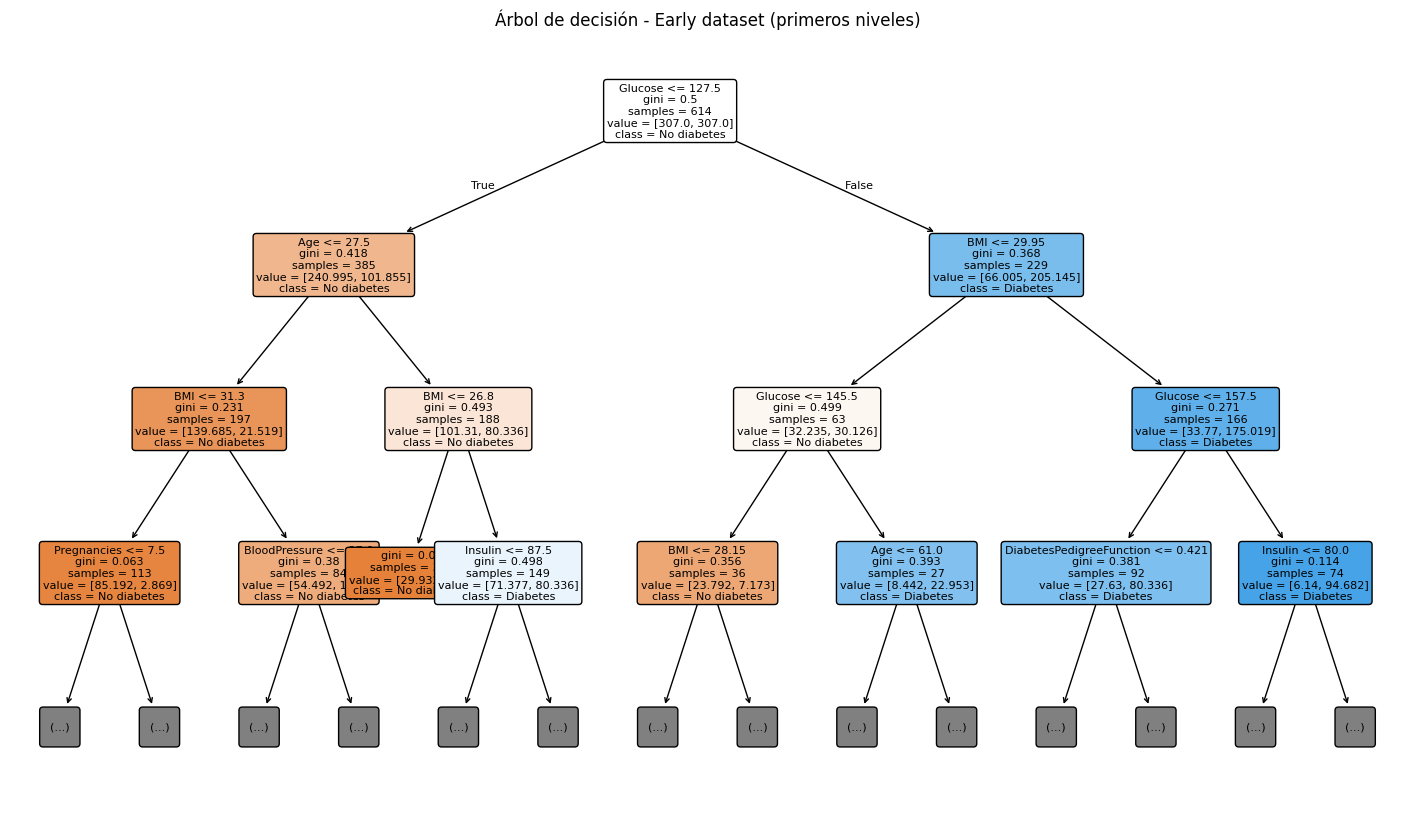

In [5]:
plt.figure(figsize=(18, 10))

plot_tree(
    tree_early,
    feature_names=X_early_train.columns,
    class_names=['No diabetes', 'Diabetes'],
    filled=True,
    rounded=True,
    max_depth=3,   # solo muestro los primeros 3 niveles para que sea legible
    fontsize=8
)

plt.title("Árbol de decisión - Early dataset (primeros niveles)")
plt.show()

In [11]:
from pickle import dump, load
dump(
    tree_early,
    open("../models/tree_early_base.sav", "wb")
)


In [6]:
# Datos del dataset EARLY
X_train = X_early_train
y_train = y_early_train
X_test  = X_early_test
y_test  = y_early_test

# Modelo base
tree = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

# Espacio de búsqueda
param_grid = {
    "max_depth": [3, 4, 5, 6, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "criterion": ["gini", "entropy"]
}

# Usamos F1 de la clase positiva como métrica principal
grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring="f1",   # en binario toma la clase 1 como positiva
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor F1 (cv):", grid.best_score_)

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
Mejor F1 (cv): 0.6797450721578416


In [7]:
best_tree = grid.best_estimator_

In [8]:
y_pred = best_tree.predict(X_test)

print("\n=== ÁRBOL OPTIMIZADO (EARLY) ===")
print("Accuracy test:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


=== ÁRBOL OPTIMIZADO (EARLY) ===
Accuracy test: 0.7142857142857143

Matriz de confusión:
 [[64 36]
 [ 8 46]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      0.64      0.74       100
           1       0.56      0.85      0.68        54

    accuracy                           0.71       154
   macro avg       0.72      0.75      0.71       154
weighted avg       0.77      0.71      0.72       154



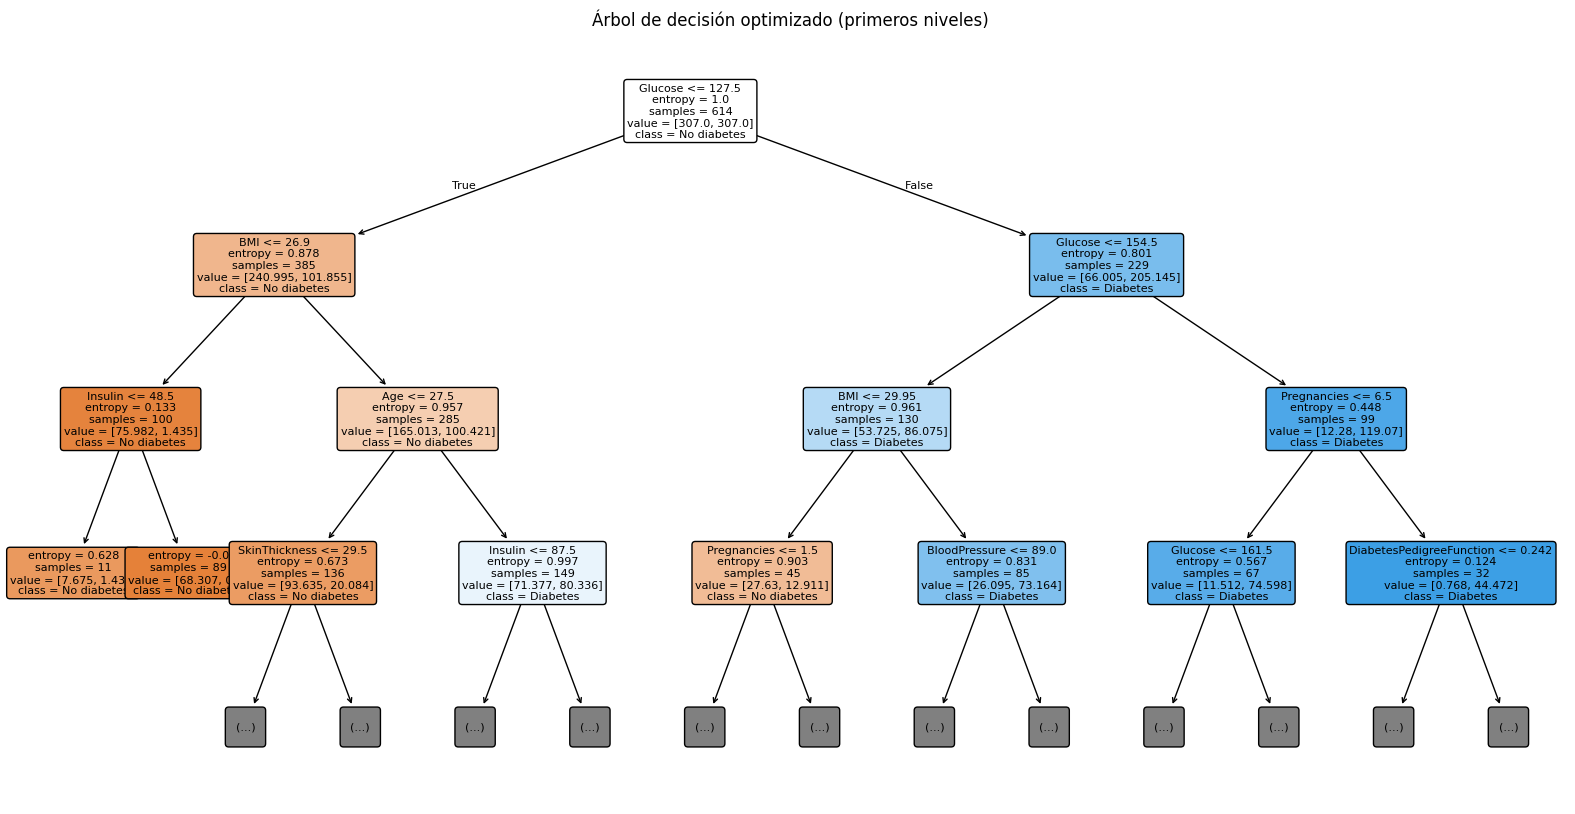

In [9]:

plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X_train.columns,
    class_names=["No diabetes", "Diabetes"],
    filled=True,
    rounded=True,
    max_depth=3,   # solo para que la figura sea legible
    fontsize=8
)
plt.title("Árbol de decisión optimizado (primeros niveles)")
plt.show()

In [12]:
dump(
    best_tree,
    open("../models/tree_early_opt_crit-entro_maxdepth-8_minleaf-2_minsplit-11_42.sav", "wb")
)

### **Optimización del árbol de decisión**

A partir del modelo base, se realizó una búsqueda de hiperparámetros mediante
`GridSearchCV` (validación cruzada de 5 folds) utilizando como métrica de
optimización el F1–score de la clase positiva (pacientes con diabetes). El
espacio de búsqueda incluyó los parámetros `max_depth`, `min_samples_split`,
`min_samples_leaf` y el `criterion`.

Los mejores hiperparámetros encontrados fueron:

- `criterion = 'entropy'`
- `max_depth = 4`
- `min_samples_leaf = 8`
- `min_samples_split = 2`

Con estos valores, el modelo obtiene un **F1 medio en validación cruzada de
≈ 0.68**.

Evaluado sobre el conjunto de test, el árbol optimizado alcanza:

- **Accuracy:** 0.71  
- **Matriz de confusión:**

  - TN = 64  
  - FP = 36  
  - FN = 8  
  - TP = 46  

- **Clase 0 (no diabetes)**  
  - Precisión: 0.89  
  - Recall: 0.64  

- **Clase 1 (diabetes)**  
  - Precisión: 0.56  
  - **Recall: 0.85**  
  - F1–score: 0.68  

En comparación con el árbol base, la accuracy global se mantiene en torno al
71–73 %, pero el **recall de la clase positiva pasa de ~0.57 a ~0.85**. Es
decir, el modelo optimizado detecta muchos más pacientes diabéticos a costa de
incrementar el número de falsos positivos. Dado que en un contexto médico es
más crítico minimizar los falsos negativos (no detectar a un paciente con
diabetes), este árbol optimizado se considera una mejora respecto al modelo
inicial y se selecciona como modelo final del proyecto.
